# Modeling Extremes - From Scratch

In [17]:
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import seaborn as sns
import regionmask
from pyextremes import get_extremes, get_return_periods
from pyextremes.plotting import plot_extremes
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [2]:
# data_url = "/pool/datos/reanalisis/era5/daily/spain/025/t2max/*.nc"
data_url = "/pool/datos/reanalisis/era5/anomaly/spain/025/t2max/*.nc"
ds = xr.open_mfdataset(data_url)

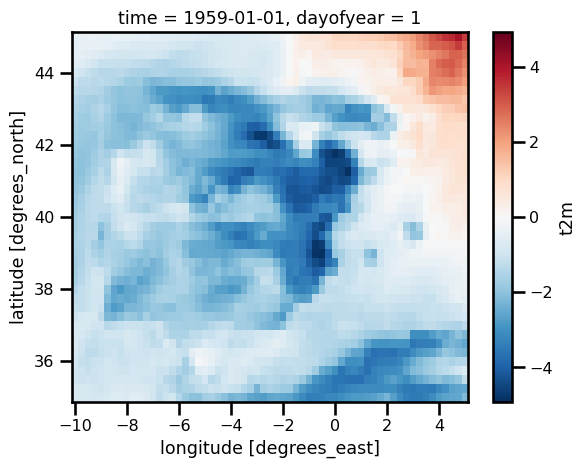

In [3]:
ds.t2m.isel(time=0).plot.pcolormesh()

## Masking

In [4]:
# get countries mask
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
# create mask variable
mask = countries.mask_3D(ds)
# select Spain mask
spain_mask = mask.isel(region=(mask.names=="Spain")).squeeze()

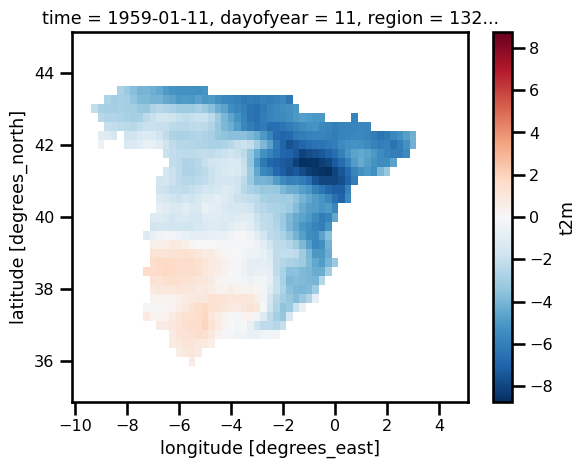

In [5]:
ds.where(spain_mask.squeeze()).isel(time=10).t2m.plot()

In [6]:
# get land-sea-mask mask
land_110 = regionmask.defined_regions.natural_earth_v5_0_0.land_110
# create land mask variable
land_mask = land_110.mask_3D(ds)

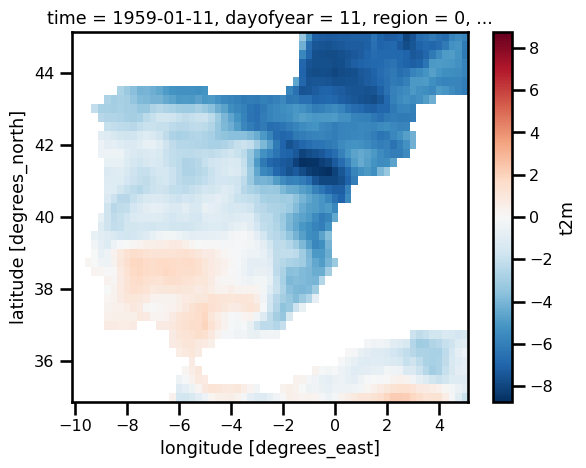

In [7]:
ds.where(land_mask.squeeze()).isel(time=10).t2m.plot()

## Clean Data

* Take Weighted Mean
* Convert Kelvin to Celsius
* Convert to DataFrame & Series
* Drop NANS
* Sort according to time
* Small Correction to Date

In [8]:
# # take weighted spatial mean
# import numpy as np
# weights = spain_mask.squeeze() * np.cos(np.deg2rad(ds.latitude))
# ds = xr.open_mfdataset(data_url)
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"]) - 272.15

### Region Selection

We are going to select Spain but also perhaps Madrid.

In [9]:
# # take weighted spatial mean
# weights = spain_mask * np.cos(np.deg2rad(ds.latitude))
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"])

# select MADRID region
data = ds.sel(longitude=-3.703790, latitude=40.416775, method="nearest")

In [10]:

# # convert Kelvin to Celcius
# data -= 272.15
# convert to dataframe
data = data.t2m.to_dataframe()
# create time series
data = pd.Series(data["t2m"])
# remove nans
data = data.dropna()
# sort ascending
data = data.sort_index(ascending=True)
# # start time
t0 = data.index[0]
# # rescale time
data = data - (data.index.array - pd.to_datetime(t0.year)) / pd.to_timedelta("365.2425D") * 2.87e-3
data.describe()

count    23011.000000
mean        -0.382247
std          3.740105
min        -16.210242
25%         -2.915719
50%         -0.283981
75%          2.215052
max         12.947272
Name: t2m, dtype: float64

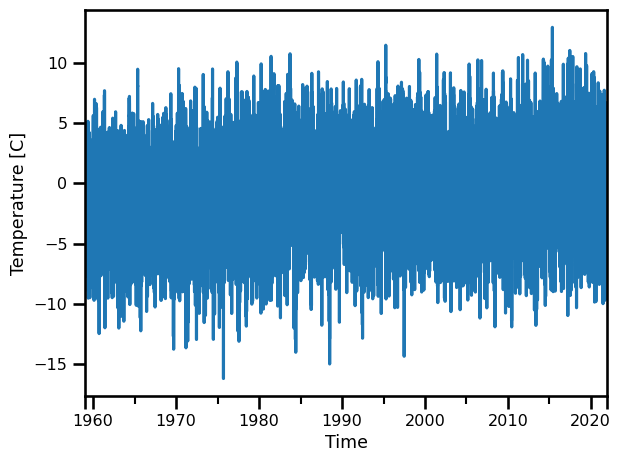

In [11]:
fig, ax = plt.subplots()

data.plot(ax=ax)

ax.set(
    xlabel="Time",
    ylabel="Temperature [C]"
)
plt.tight_layout()
plt.show()

## Extremes

In [14]:
extremes_method = "BM"
block_size = f"{3*30}D" # "365.2425D" # 
extremes_type = "high"
extremes = get_extremes(
    data, 
    method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

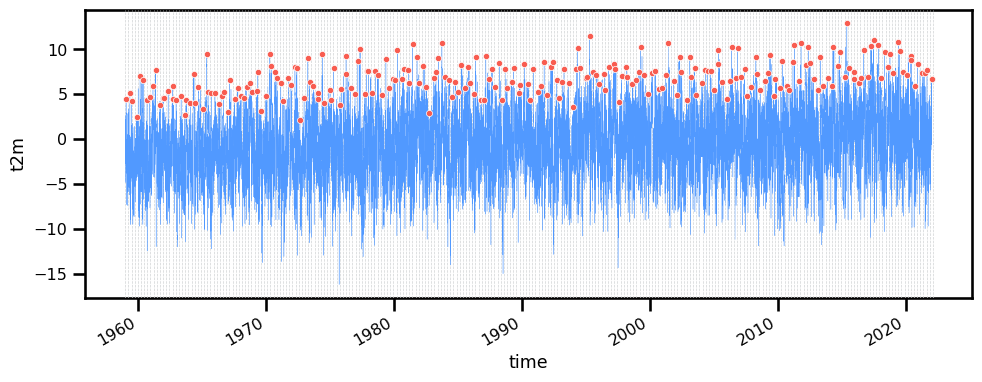

In [15]:
fig, ax = plt.subplots(figsize=(10,4))

plot_extremes(
    ax=ax,
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

plt.tight_layout()
plt.show()

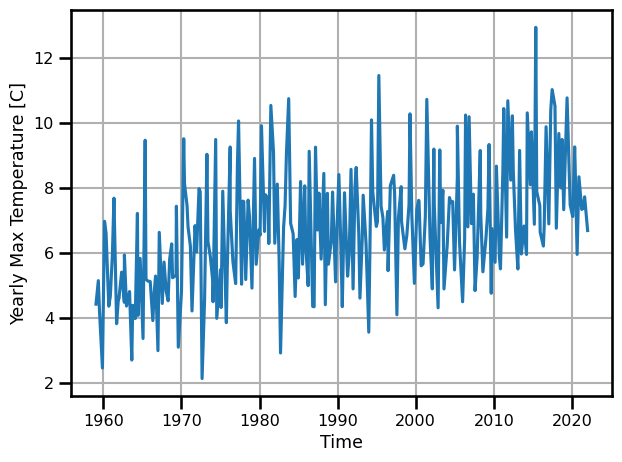

In [16]:
fig, ax = plt.subplots()

ax.plot(extremes)
ax.set(
    xlabel="Time",
    ylabel="Yearly Max Temperature [C]"
)
plt.grid(which="both", visible=True)
plt.tight_layout()
plt.show()

## Diagnostics

In [18]:
return_periods = get_return_periods(
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type,
    block_size=block_size,
    return_period_size=block_size,
    plotting_position="weibull",
)
# 
return_periods = return_periods.sort_values(by="return period", ascending=False)

In [19]:
return_periods

,t2m,exceedance probability,return period
time,,,
2015-05-13,12.947272,0.003891,257.000000
1995-04-10,11.463034,0.007782,128.500000
2017-06-17,11.030958,0.011673,85.666667
2019-05-15,10.774879,0.015564,64.250000
1983-09-25,10.752610,0.019455,51.400000
...,...,...,...
1966-12-31,2.989370,0.980545,1.019841
1982-09-09,2.919151,0.984436,1.015810
1963-08-26,2.699681,0.988327,1.011811


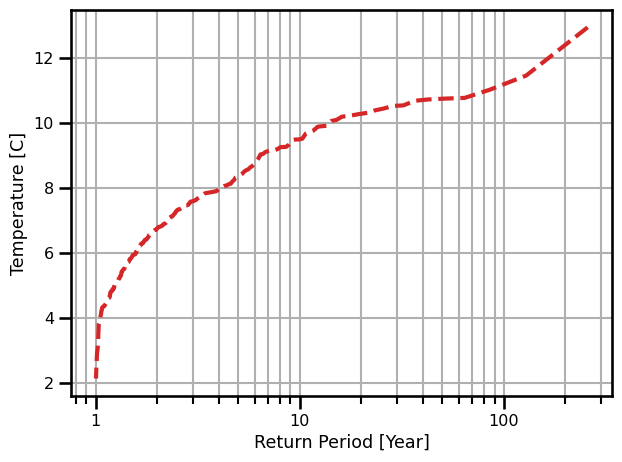

In [20]:
fig, ax = plt.subplots()

ax.plot(
    return_periods["return period"],
    return_periods["t2m"], 
    linestyle="--", linewidth=3, color="tab:red"
    
)
ax.set(
    xlabel="Return Period [Year]",
    ylabel="Temperature [C]",
    xscale="log",
    xticks=[1.0, 10.0, 100.0]
    
)

# format log scale labels
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

plt.grid(which="both", visible=True)

plt.tight_layout()
plt.show()